# Breakout-ram-v0
description : https://gym.openai.com/envs/Breakout-ram-v0/

In [1]:
import gym
import numpy as np
import renom as rm

import matplotlib.pyplot as plt

from renom_rl.discrete.double_dqn import DoubleDQN
from renom_rl.environ.env import BaseEnv
from renom_rl.utility.filter import EpsilonEIFilter
from renom_rl.utility import Animation

from renom.cuda import set_cuda_active
set_cuda_active(True)

In [2]:
class Breakout(BaseEnv):
    
    def __init__(self):
        self.env = gym.make('Breakout-ramNoFrameskip-v4')
        self.action_shape = (self.env.action_space.n,)
        self.state_shape = self.env.observation_space.shape
        print("Env Space : ", self.state_shape)
        print("Action Space : ", self.action_shape)
        
        self.action_interval = 4
        self.real_done = True
        self.lives = 0
        self.max_time_length = 10000
        self.time_step = 0

        self.animation = Animation(ratio=36.0)
    
    def reset(self):
        if self.real_done:
            obs = self.env.reset()
            n_step = np.random.randint(5)
            for _ in range(n_step):
                obs, _, _ = self.step(0)
        else:
            obs, _, _ = self.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs
    
    def sample(self):
        return self.env.action_space.sample()
    
    def _concat_state(self, state_list):
        max_ram_data = np.zeros(state_list[0].shape)
        for d in state_list:
            max_ram_data = np.maximum(d, max_ram_data)
        max_ram_data /= 255.0
        return max_ram_data
    
    def step(self, action):
        state_list = []
        reward_list = []
        self.real_done = False
        self.time_step += 1
        
        for _ in range(self.action_interval):
            state, reward, terminal, _ = self.env.step(int(action))
            state_list.append(state)
            reward_list.append(reward)
            
            if terminal:
                self.real_done = True
                self.time_step = 0
                break
        
        processed_state = self._concat_state(state_list)
        
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            terminal = True
            self.time_step = 0
        self.lives = lives
        
        if self.time_step > self.max_time_length:
            self.real_done = True
            terminal = True
            self.time_step = 0
        
        return processed_state, sum(reward_list), terminal

    def test_start(self):
        self.animation.reset()
        self.env.reset()
    
    def test_epoch_step(self):
        self.animation.store(self.env.render(mode="rgb_array"))
    
    def test_close(self):
        #self.env.close() 
        self.env.viewer = None
                
            
env = Breakout()

q_network = rm.Sequential([ rm.Dense(150),
                                                   rm.Relu(),
                                                   rm.Dense(100),
                                                   rm.Relu(),
                                                   rm.Dense(env.action_shape[0])
                                                ])

Env Space :  (128,)
Action Space :  (4,)


In [3]:
fil = EpsilonEIFilter(min=0.1,max=1.0, initial=1.0, alpha=0.005)

agent = DoubleDQN(env, q_network)
agent.fit(epoch=1, 
          epoch_step=1000,
          update_period=10,  
          batch_size=32,
          random_step=200,
          action_filter=fil)

epoch 0001 epsilon 1.0000 loss 0.1373 rewards in epoch 0.000 episode 0000 rewards in episode 0.000.:   2%|▏         | 23/1000 [00:00<00:03, 321.96it/s]

Run random 200 step for storing experiences


epoch 001 avg_loss:0.0022 total reward in epoch: [train:7.000 test: 1.0] avg train reward in episode:0.259 e-greedy:0.893: 100%|██████████| 1000/1000 [00:03<00:00, 299.35it/s]


reward of one episode is  1.0
length of animation :  61



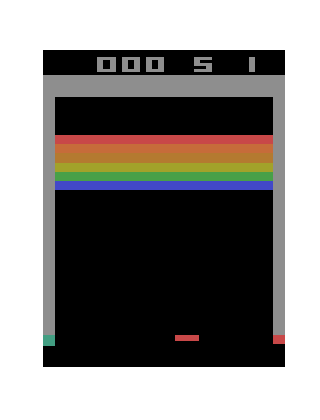
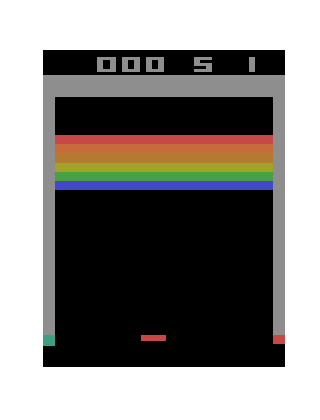
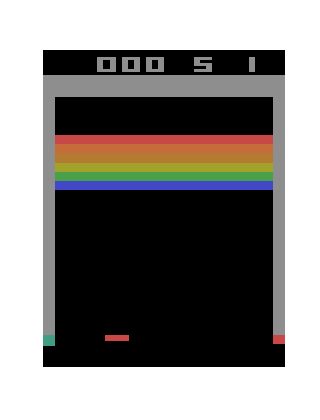
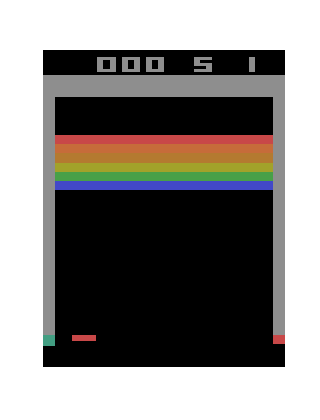
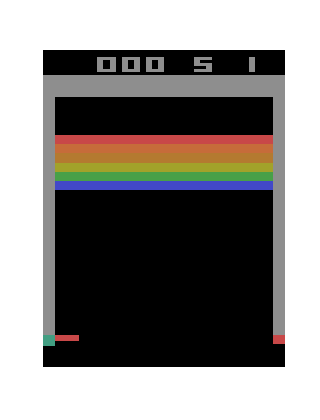
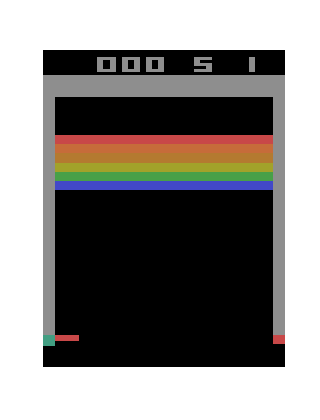
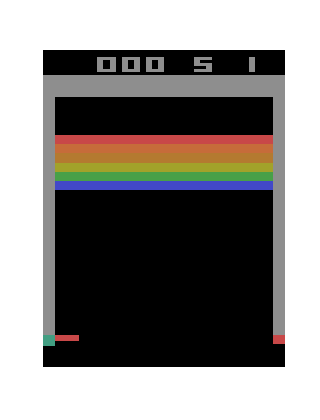
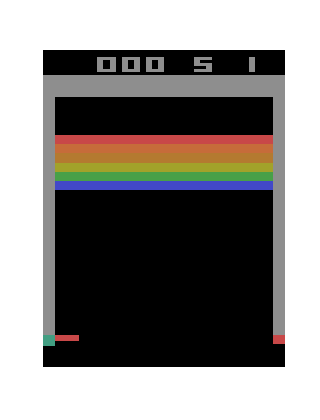
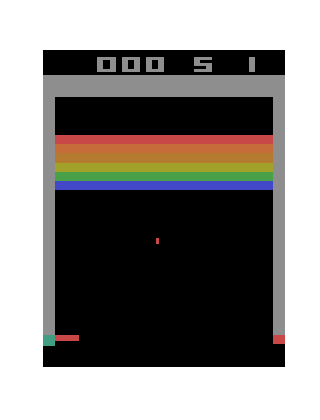
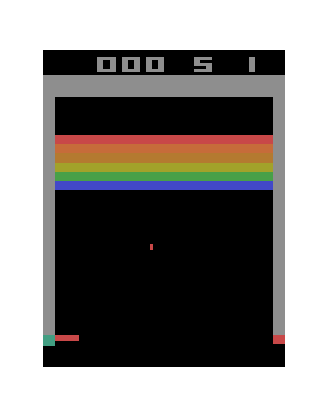
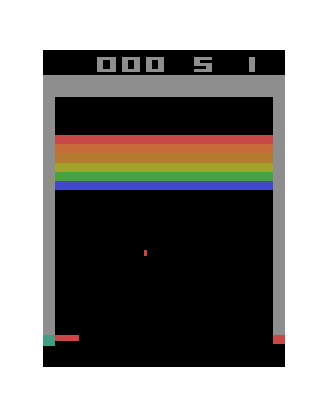
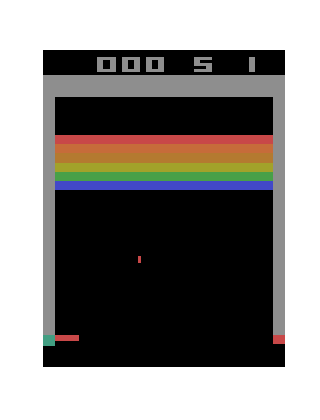
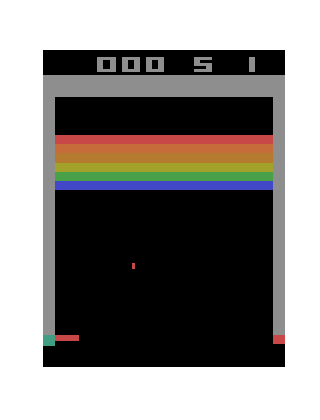
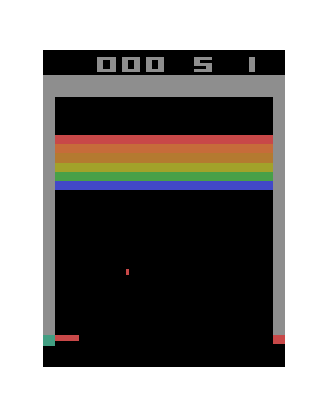
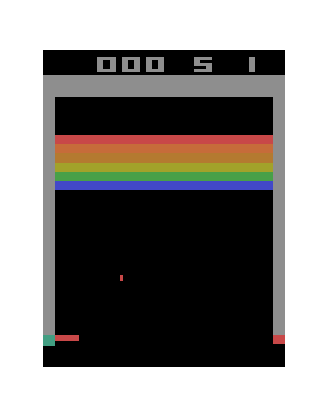
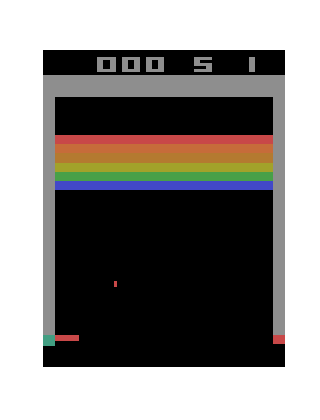
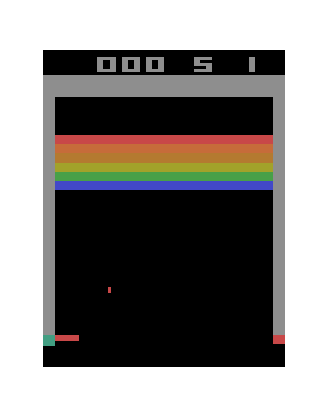
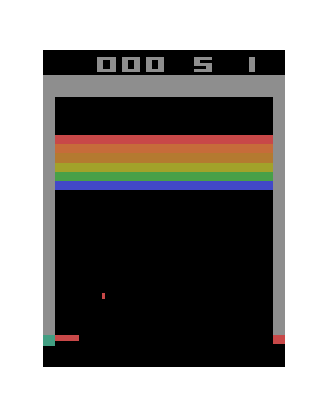
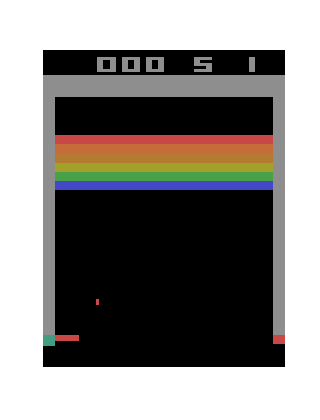
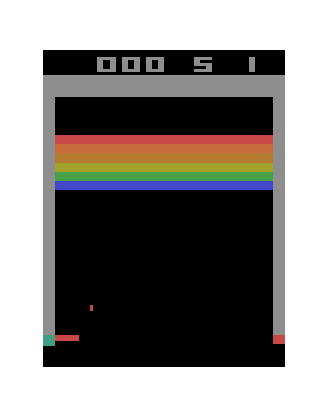
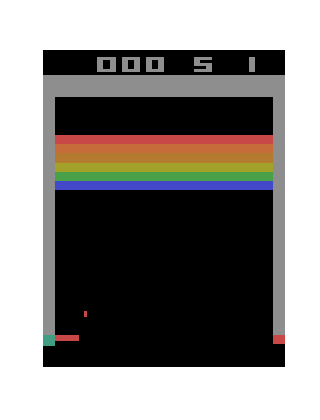
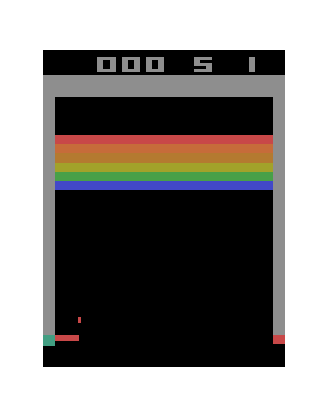
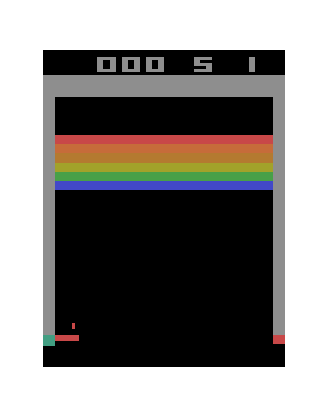
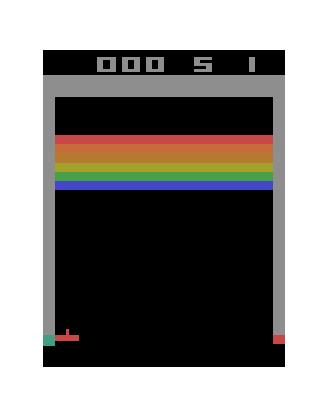
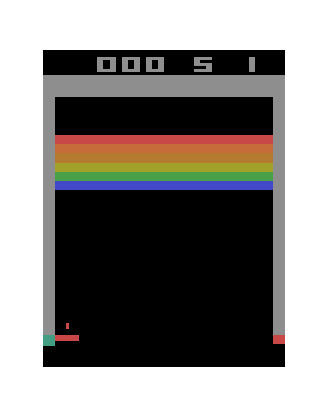
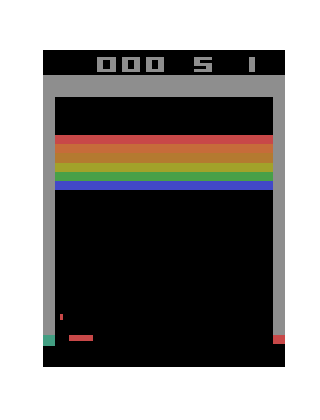
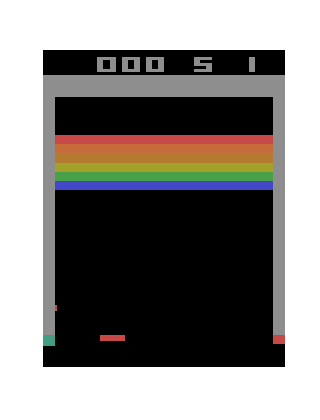
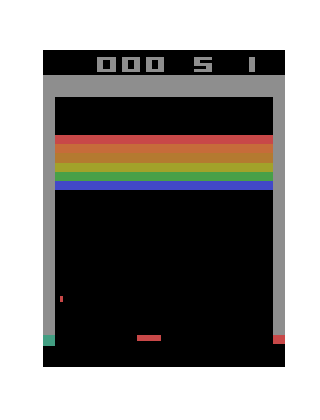
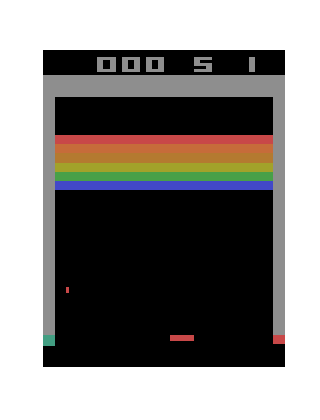
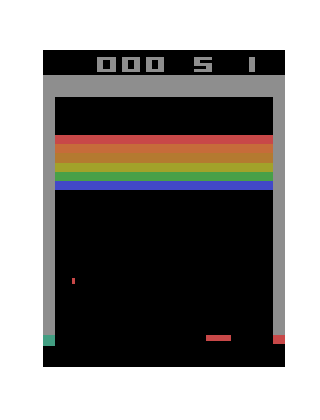
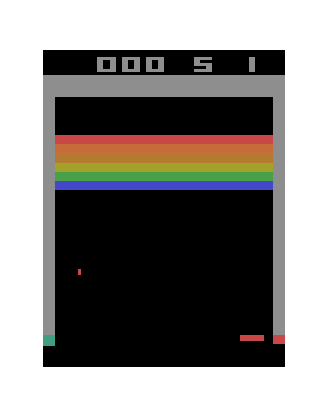
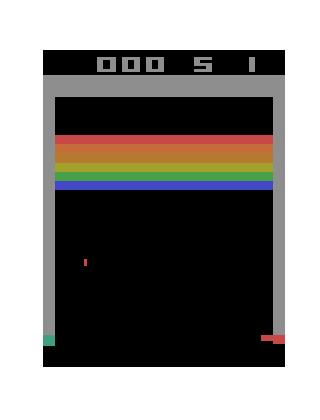
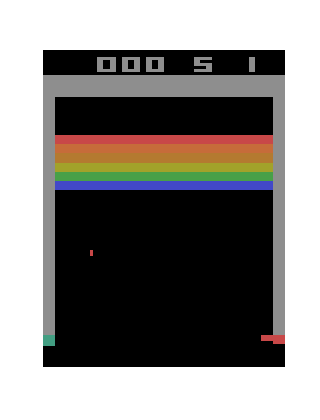
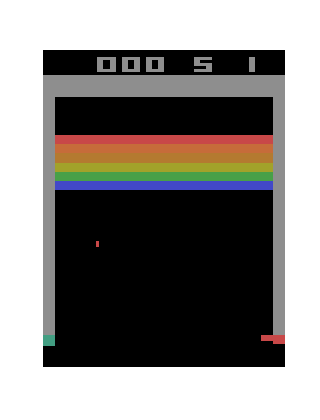
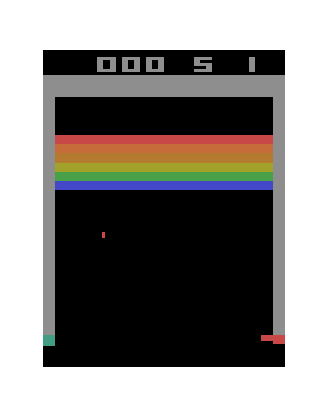
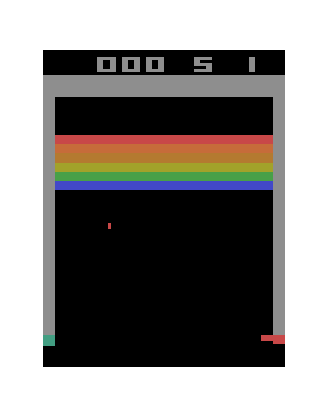
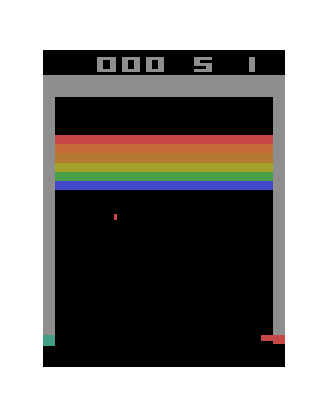
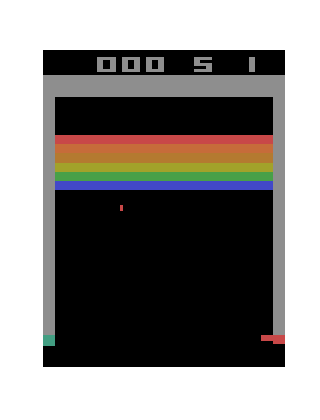
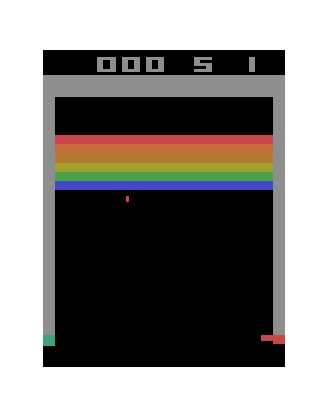
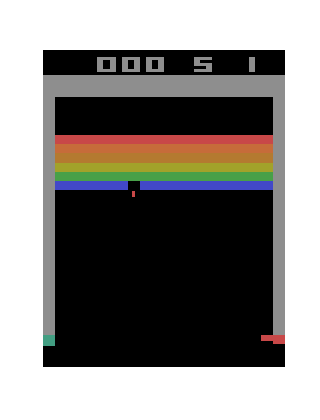
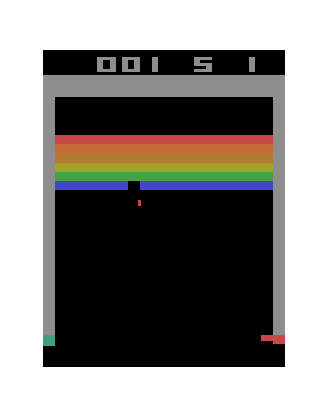
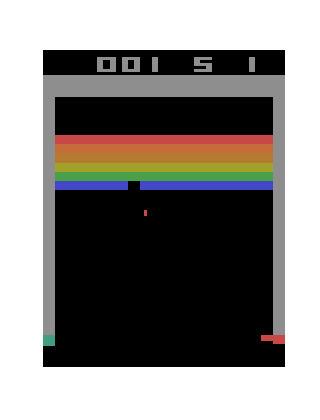
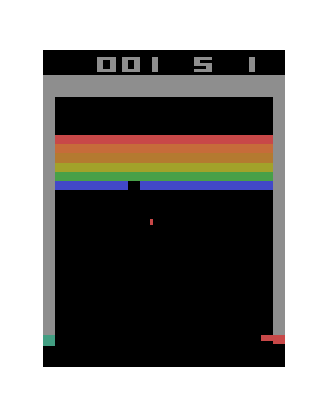
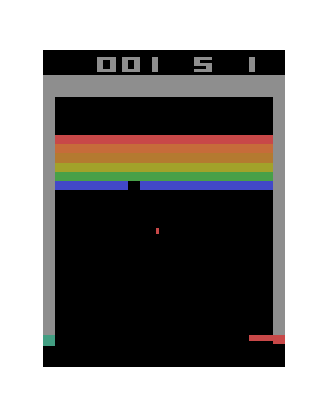
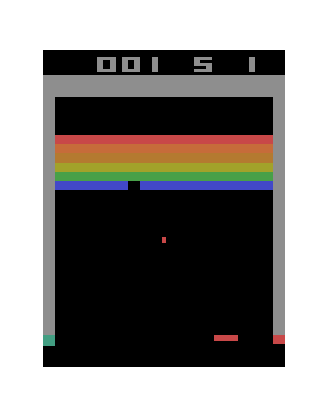
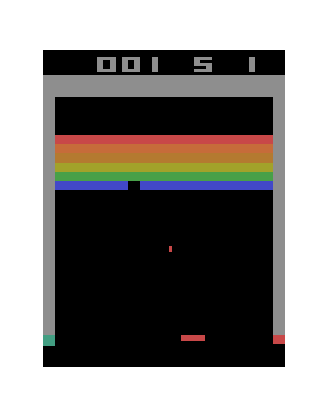
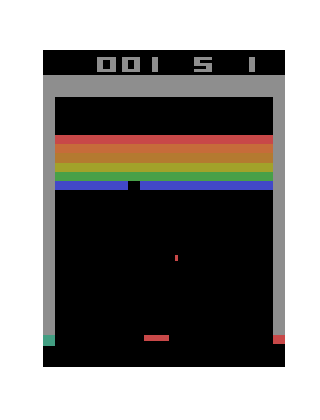
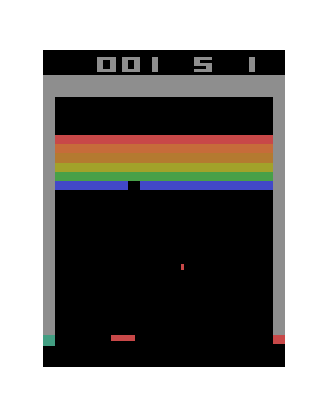
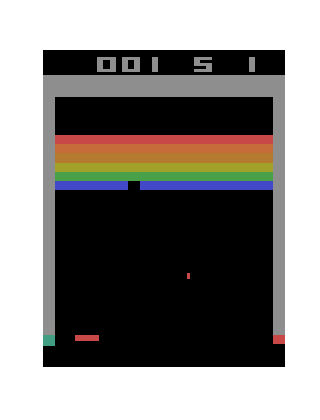
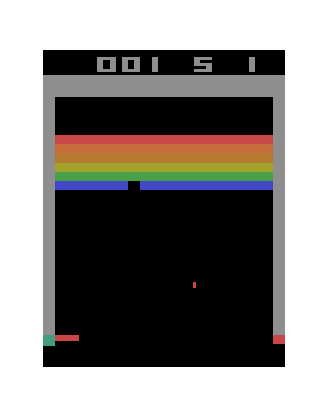
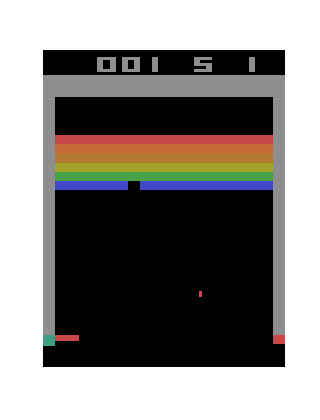
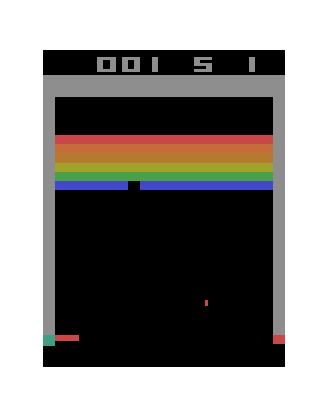
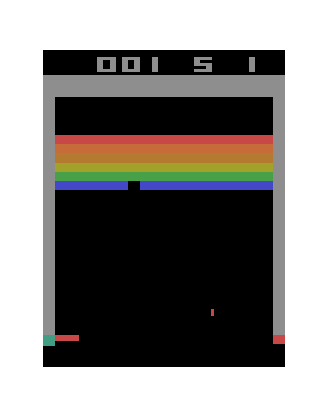
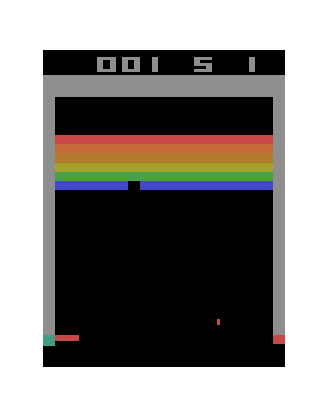
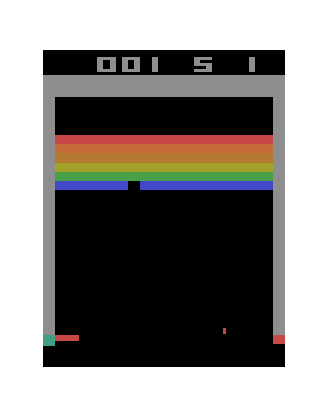
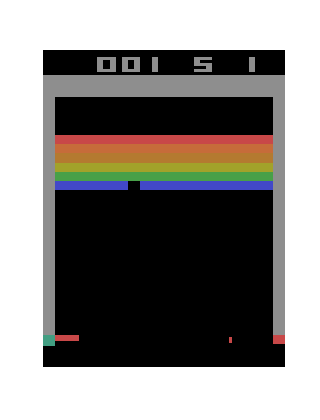
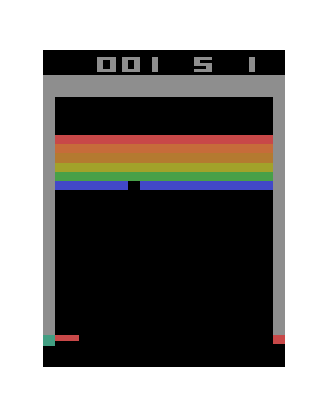
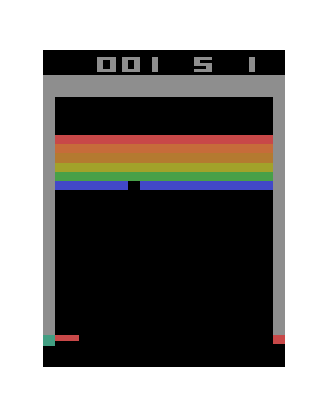
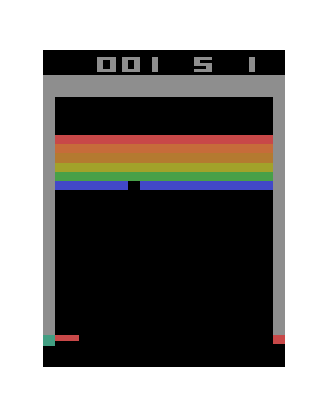
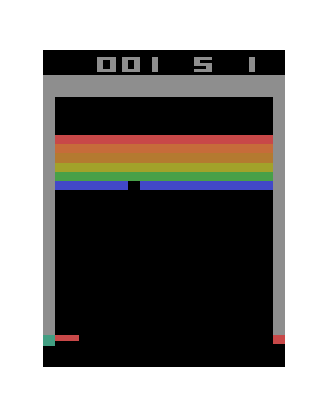
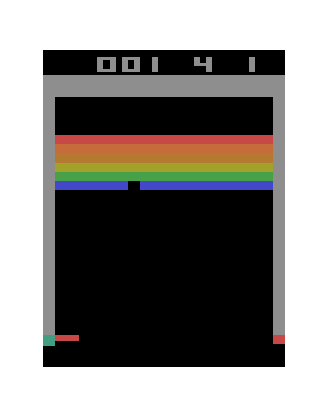

In [4]:
print('reward of one episode is ', agent.test(test_step=None))
print('length of animation : ', len(env.animation))
env.animation.run()
q_network.save("ddqn_breakout-ram.h5")